In [422]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [423]:
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

In [424]:
df_bmw=pd.read_csv("data/bmw_pricing_v3.csv")

# Funciones

In [425]:
def obtener_lista_variables(dataset):
    lista_numericas=[]
    lista_boolean=[]
    lista_categoricas=[]

    for i in dataset:
        if    (dataset[i].dtype.kind in ("f","i")) and len(dataset[i].unique())!= 2  and i not in target:
              lista_numericas.append(i)
        elif  (((dataset[i].dtype.kind in ("f","i")) and len(dataset[i].unique())== 2) or (set(df2[i].unique()) == {True ,False, np.nan} )or dataset[i].dtype.kind =="b")  and i not in target:
              lista_boolean.append(i)
        elif  (dataset[i].dtype.kind == "O")  and i not in target:
              lista_categoricas.append(i)
                
    return lista_numericas, lista_boolean, lista_categoricas

In [426]:
def unicos(df):
    for i in df:
        if df[i].dtype.kind == "O":
             print(i,df[i].unique(),"\n")
        elif (df[i].dtype.kind=="f") or (df[i].dtype.kind=="i"):
            print(df.hist(i))     

In [427]:
def valcounts(df):
    for i in df:
        if df[i].dtype.kind == "O":
            print(i,"\n", df[i].value_counts(), "\n")

In [428]:
#columnas con nulos bajo umbral
def nulosbajosumbral(df,umbral):
    listanulos=[]
    for i in df:
        if (df[i].isnull().sum()/len(df))<umbral:
            listanulos.append(i)
    return listanulos        

In [429]:
#remueve nulos de columnas especificas
def remuevenulos(df,columnas):
    for i in columnas:
        df.dropna(subset=[i], inplace=True)
    return df    

In [430]:
# Rellena nulos con la moda de cada agrupacion de una columna
def modaxclase(lista,df,cclase):
    for i in lista:
        moda = df.groupby(cclase)[i].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else df[i].mode().iloc[0])
        df[i] = df[i].fillna(moda)
    return df

In [431]:
def analisisvc(df,col):
    tabla=df[col].value_counts().reset_index()
    total=tabla["count"].sum()
    for i in range(0,len(tabla)):
        tabla.loc[i,"por"]=round(round(tabla.loc[i,"count"]/total,4)*100,2)
        if i==0:
            tabla.loc[i,"poracum"]=tabla.loc[i,"por"]
        else:
            tabla.loc[i,"poracum"]=tabla.loc[i-1,"poracum"]+tabla.loc[i,"por"]
    return tabla
            

In [432]:
def obten_lista_eliminar(df, col, umbral):
  lista_borrar= []
  tabla=df[col].value_counts().reset_index()
  for i in range(0,len(tabla)):
    if (tabla.iloc[i,1]) < umbral:
      lista_borrar.append(tabla.iloc[i,0])
  return lista_borrar

In [433]:
def eliminar_lista_df(dataset, columna, lista_eliminar):
  dataset.drop(dataset[dataset[columna].isin(lista_eliminar)].index, inplace=True)

In [434]:
def obten_lista_otros(df, col, umbral):
    lista_otros= []
    tabla=df[col].value_counts().reset_index()
    for i in range(0,len(tabla)):
        if (tabla.iloc[i,1]) < umbral:
            lista_otros.append(tabla.iloc[i,0])
    return lista_otros

In [435]:
def cambiar_a_otros(df, i):
    df.replace({i:"otros"}, inplace=True)

In [436]:
# Mismo analisis, pero desde una funcion que nos facilita la vida
def highly_correlated(X, y, threshold):
    col_corr = list() # Set of all the names of deleted columns
    colnames = list()
    rownames = list()
    corr_matrix = X.corr().abs()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colnames.append(corr_matrix.columns[i]) # getting the name of column
                rownames.append(corr_matrix.index[j])
                col_corr.append(corr_matrix.iloc[i, j])
    Z = pd.DataFrame({'F1':colnames,
                      'F2':rownames,
                      'corr_F1_F2':col_corr,
                      'corr_F1_target': [np.abs(np.corrcoef(X[i],y)[0,1]) for i in colnames],
                      'corr_F2_target': [np.abs(np.corrcoef(X[i],y)[0,1]) for i in rownames]
                      })
    Z['F_to_delete'] = rownames
    Z['F_to_delete'][Z['corr_F1_target'] < Z['corr_F2_target']] = Z['F1'][Z['corr_F1_target'] < Z['corr_F2_target']]

    return Z

# Estructura de Datos

In [437]:
df_bmw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   marca                        3873 non-null   object 
 1   modelo                       4840 non-null   object 
 2   km                           4841 non-null   float64
 3   potencia                     4842 non-null   float64
 4   fecha_registro               2420 non-null   object 
 5   tipo_gasolina                4838 non-null   object 
 6   color                        4398 non-null   object 
 7   tipo_coche                   3383 non-null   object 
 8   volante_regulable            4839 non-null   object 
 9   aire_acondicionado           4357 non-null   object 
 10  camara_trasera               4841 non-null   object 
 11  asientos_traseros_plegables  1452 non-null   object 
 12  elevalunas_electrico         4841 non-null   object 
 13  bluetooth         

In [438]:
df_bmw.shape

(4843, 18)

In [439]:
df_bmw.head(5)

,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
0,NaN,118,140411.0,100.0,2012-02-01,diesel,black,NaN,True,True,False,NaN,True,NaN,True,NaN,11300.0,2018-01-01
1,BMW,M4,13929.0,317.0,NaN,petrol,grey,convertible,True,True,False,NaN,False,True,True,True,69700.0,2018-02-01
2,BMW,320,183297.0,120.0,2012-04-01,diesel,white,NaN,False,False,False,NaN,True,False,True,False,10200.0,2018-02-01
3,BMW,420,128035.0,135.0,NaN,diesel,red,convertible,True,True,False,NaN,True,True,True,NaN,25100.0,2018-02-01
4,BMW,425,97097.0,160.0,NaN,diesel,silver,NaN,True,True,False,False,False,True,True,True,33400.0,2018-04-01


# Cleaning

In [440]:
df2=df_bmw.copy()

In [441]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   marca                        3873 non-null   object 
 1   modelo                       4840 non-null   object 
 2   km                           4841 non-null   float64
 3   potencia                     4842 non-null   float64
 4   fecha_registro               2420 non-null   object 
 5   tipo_gasolina                4838 non-null   object 
 6   color                        4398 non-null   object 
 7   tipo_coche                   3383 non-null   object 
 8   volante_regulable            4839 non-null   object 
 9   aire_acondicionado           4357 non-null   object 
 10  camara_trasera               4841 non-null   object 
 11  asientos_traseros_plegables  1452 non-null   object 
 12  elevalunas_electrico         4841 non-null   object 
 13  bluetooth         

In [442]:
df2[df2.duplicated(keep=False)] # sin duplicados

,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta


In [443]:
for i in ["fecha_registro","fecha_venta"]:
    df2[i]=pd.to_datetime(df2[i])

In [444]:
df2["precio"].isnull().sum()

6

In [445]:
df2.dropna(subset=["precio"], inplace=True)

# EDA

In [446]:
target= "precio"

In [447]:
df2.describe().T

,count,mean,min,25%,50%,75%,max,std
km,4835.0,140966.371251,-64.0,102870.0,141068.0,175243.5,1000376.0,60220.786757
potencia,4836.0,128.995037,0.0,100.0,120.0,135.0,423.0,39.011169
fecha_registro,2419,2012-12-06 04:18:56.998759936,1990-03-01 00:00:00,2012-07-01 00:00:00,2013-07-01 00:00:00,2014-04-01 00:00:00,2017-11-01 00:00:00,NaN
precio,4837.0,15831.920612,100.0,10800.0,14200.0,18600.0,178500.0,9222.630708
fecha_venta,4836,2018-04-26 13:24:33.945409280,2007-08-01 00:00:00,2018-03-01 00:00:00,2018-05-01 00:00:00,2018-07-01 00:00:00,2018-09-01 00:00:00,NaN


## Deteccion y tratamiento de nulos

In [448]:
df2.isnull().sum()

marca                           970
modelo                            3
km                                2
potencia                          1
fecha_registro                 2418
tipo_gasolina                     5
color                           444
tipo_coche                     1458
volante_regulable                 4
aire_acondicionado              485
camara_trasera                    2
asientos_traseros_plegables    3388
elevalunas_electrico              2
bluetooth                       728
gps                               0
alerta_lim_velocidad            728
precio                            0
fecha_venta                       1
dtype: int64

marca [nan 'BMW'] 

modelo ['118' 'M4' '320' '420' '425' '335' '325' 'Z4' '120' '220' '650' '135'
 '218' '318' '430' 'M3' '330' '225' 'M235' '316' '435' '640'
 '640 Gran Coupé' '435 Gran Coupé' 'i8' '630' '430 Gran Coupé' '635' '520'
 nan '525' '530' '535' '320 Gran Turismo' '518' '116' '328' '523' 'X3'
 'M550' '528' '325 Gran Turismo' '125' '318 Gran Turismo' '420 Gran Coupé'
 'i3' '114' '520 Gran Turismo' '530 Gran Turismo' 'M135' '418 Gran Coupé'
 '330 Gran Turismo' '335 Gran Turismo' '730' '123' '535 Gran Turismo'
 '740' '750' 'ActiveHybrid 5' '735' 'M5' 'X5' 'X1' 'X4' 'X6' 'X6 M' 'X5 M'
 'X5 M50' '218 Active Tourer' '218 Gran Tourer' '216' '220 Active Tourer'
 '216 Gran Tourer' '216 Active Tourer' ' Active Tourer'
 '225 Active Tourer' '214 Gran Tourer'] 

[[<Axes: title={'center': 'km'}>]]
[[<Axes: title={'center': 'potencia'}>]]
tipo_gasolina ['diesel' 'petrol' nan 'hybrid_petrol' 'Diesel' 'electro'] 

color ['black' 'grey' 'white' 'red' 'silver' 'blue' nan 'orange' 'beige' 'brow

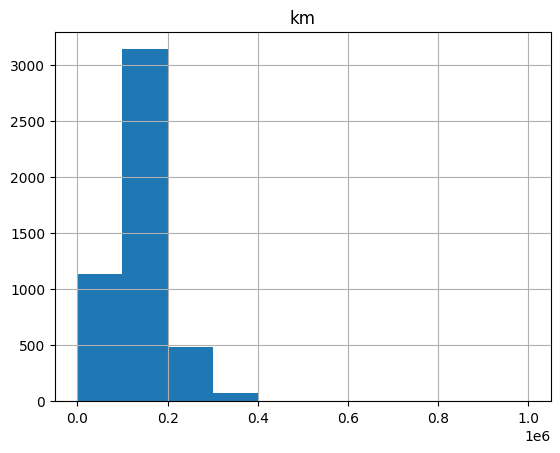

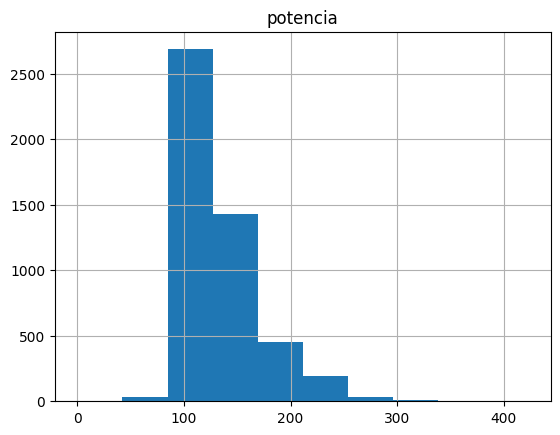

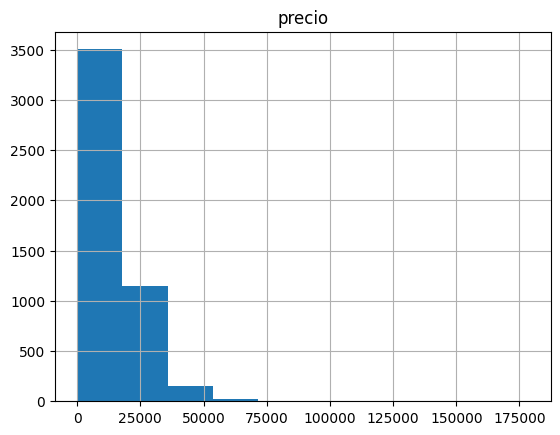

In [449]:
unicos(df2)

In [450]:
del(df2["marca"]) # borrar marca, se esta analizando bmw

In [451]:
del(df2["fecha_registro"]) # muchos nulos y se tiene el km para modelo de valorizacion por antiguedad/uso

In [452]:
u=0.01
l1=nulosbajosumbral(df2,u)

In [453]:
remuevenulos(df2,l1)
df2=df2.reset_index(drop=True)

In [454]:
df2.isnull().sum()

modelo                            0
km                                0
potencia                          0
tipo_gasolina                     0
color                           442
tipo_coche                     1449
volante_regulable                 0
aire_acondicionado              482
camara_trasera                    0
asientos_traseros_plegables    3373
elevalunas_electrico              0
bluetooth                       725
gps                               0
alerta_lim_velocidad            725
precio                            0
fecha_venta                       0
dtype: int64

In [455]:
for i in df2:
    if set(df2[i].unique()) == {True ,False}:
        df2[i]=df2[i].astype(bool)

In [456]:
valcounts(df2)

modelo 
 modelo
320                747
520                630
318                562
X3                 437
116                358
                  ... 
M135                 1
225                  1
i8                   1
630                  1
214 Gran Tourer      1
Name: count, Length: 76, dtype: int64 

tipo_gasolina 
 tipo_gasolina
diesel           4610
petrol            191
hybrid_petrol       8
Diesel              5
electro             3
Name: count, dtype: int64 

color 
 color
black     1489
grey      1067
blue       643
white      480
brown      302
silver     290
red         47
beige       37
green       14
orange       6
Name: count, dtype: int64 

tipo_coche 
 tipo_coche
estate         1097
sedan           821
suv             754
hatchback       488
subcompact       77
coupe            73
convertible      30
van              28
Name: count, dtype: int64 

aire_acondicionado 
 aire_acondicionado
True     3449
False     886
Name: count, dtype: int64 

asientos_traseros_plega

### Imputar Nulos

In [457]:
df3=df2.copy()

In [458]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4817 entries, 0 to 4816
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   modelo                       4817 non-null   object        
 1   km                           4817 non-null   float64       
 2   potencia                     4817 non-null   float64       
 3   tipo_gasolina                4817 non-null   object        
 4   color                        4375 non-null   object        
 5   tipo_coche                   3368 non-null   object        
 6   volante_regulable            4817 non-null   bool          
 7   aire_acondicionado           4335 non-null   object        
 8   camara_trasera               4817 non-null   bool          
 9   asientos_traseros_plegables  1444 non-null   object        
 10  elevalunas_electrico         4817 non-null   bool          
 11  bluetooth                    4092 non-null 

In [459]:
df3.isnull().sum()

modelo                            0
km                                0
potencia                          0
tipo_gasolina                     0
color                           442
tipo_coche                     1449
volante_regulable                 0
aire_acondicionado              482
camara_trasera                    0
asientos_traseros_plegables    3373
elevalunas_electrico              0
bluetooth                       725
gps                               0
alerta_lim_velocidad            725
precio                            0
fecha_venta                       0
dtype: int64

In [460]:
for col in ["fecha_venta"]:
    df3[col + '_AÑO'] = df3[col].dt.year.astype(int)
    #df3[col + '_NOMBREDIA'] = df3[col].dt.day_name()
    ##O .dt.weekday_name
    df3[col + '_DIA'] = df3[col].dt.day.astype(int)
    df3[col + '_MES'] = df3[col].dt.month.astype(int)

In [461]:
del(df3["fecha_venta"])

In [462]:
lnum, lbool, lcat= obtener_lista_variables(df3)

In [463]:
lnum

['km', 'potencia', 'fecha_venta_AÑO', 'fecha_venta_DIA', 'fecha_venta_MES']

In [464]:
lbool

['volante_regulable',
 'aire_acondicionado',
 'camara_trasera',
 'asientos_traseros_plegables',
 'elevalunas_electrico',
 'bluetooth',
 'gps',
 'alerta_lim_velocidad']

In [465]:
lcat

['modelo', 'tipo_gasolina', 'color', 'tipo_coche']

In [466]:
modaxclase(lbool,df3,"modelo");

C:\Users\rstee\AppData\Local\Temp\ipykernel_3248\1163546534.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[i] = df[i].fillna(moda)
C:\Users\rstee\AppData\Local\Temp\ipykernel_3248\1163546534.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[i] = df[i].fillna(moda)
C:\Users\rstee\AppData\Local\Temp\ipykernel_3248\1163546534.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.se

In [467]:
# for i in lbool:
#     df3[i]=df3[i].astype(int)

In [468]:
df3.isnull().sum()

modelo                            0
km                                0
potencia                          0
tipo_gasolina                     0
color                           442
tipo_coche                     1449
volante_regulable                 0
aire_acondicionado                0
camara_trasera                    0
asientos_traseros_plegables       0
elevalunas_electrico              0
bluetooth                         0
gps                               0
alerta_lim_velocidad              0
precio                            0
fecha_venta_AÑO                   0
fecha_venta_DIA                   0
fecha_venta_MES                   0
dtype: int64

In [469]:
modaxclase(lcat,df3,"modelo");

In [470]:
df3.isnull().sum()

modelo                         0
km                             0
potencia                       0
tipo_gasolina                  0
color                          0
tipo_coche                     0
volante_regulable              0
aire_acondicionado             0
camara_trasera                 0
asientos_traseros_plegables    0
elevalunas_electrico           0
bluetooth                      0
gps                            0
alerta_lim_velocidad           0
precio                         0
fecha_venta_AÑO                0
fecha_venta_DIA                0
fecha_venta_MES                0
dtype: int64

## Analisis Univariable

In [471]:
valcounts(df3)

modelo 
 modelo
320                747
520                630
318                562
X3                 437
116                358
                  ... 
M135                 1
225                  1
i8                   1
630                  1
214 Gran Tourer      1
Name: count, Length: 76, dtype: int64 

tipo_gasolina 
 tipo_gasolina
diesel           4610
petrol            191
hybrid_petrol       8
Diesel              5
electro             3
Name: count, dtype: int64 

color 
 color
black     1837
grey      1148
blue       655
white      481
brown      302
silver     290
red         47
beige       37
green       14
orange       6
Name: count, dtype: int64 

tipo_coche 
 tipo_coche
estate         1805
suv            1059
sedan           955
hatchback       750
coupe            94
subcompact       77
convertible      39
van              38
Name: count, dtype: int64 



modelo ['118' 'M4' '320' '420' '425' '335' '325' 'Z4' '120' '220' '650' '135'
 '218' '318' '430' 'M3' '330' '225' 'M235' '316' '435' '640'
 '640 Gran Coupé' '435 Gran Coupé' 'i8' '630' '430 Gran Coupé' '635' '520'
 '525' '530' '535' '320 Gran Turismo' '518' '116' '328' '523' 'X3' 'M550'
 '528' '325 Gran Turismo' '125' '318 Gran Turismo' '420 Gran Coupé' 'i3'
 '114' '520 Gran Turismo' '530 Gran Turismo' 'M135' '418 Gran Coupé'
 '330 Gran Turismo' '335 Gran Turismo' '730' '123' '535 Gran Turismo'
 '740' '750' 'ActiveHybrid 5' '735' 'M5' 'X5' 'X1' 'X4' 'X6' 'X6 M' 'X5 M'
 'X5 M50' '218 Active Tourer' '218 Gran Tourer' '216' '220 Active Tourer'
 '216 Gran Tourer' '216 Active Tourer' ' Active Tourer'
 '225 Active Tourer' '214 Gran Tourer'] 

[[<Axes: title={'center': 'km'}>]]
[[<Axes: title={'center': 'potencia'}>]]
tipo_gasolina ['diesel' 'petrol' 'hybrid_petrol' 'Diesel' 'electro'] 

color ['black' 'grey' 'white' 'red' 'silver' 'blue' 'orange' 'beige' 'brown'
 'green'] 

tipo_coche ['hatc

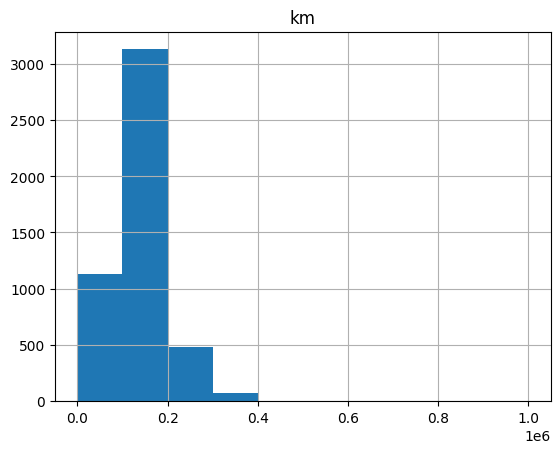

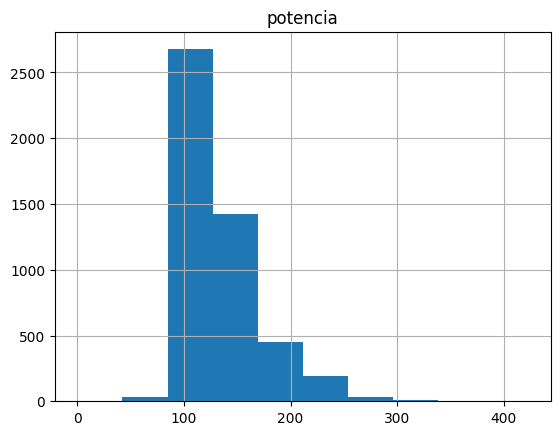

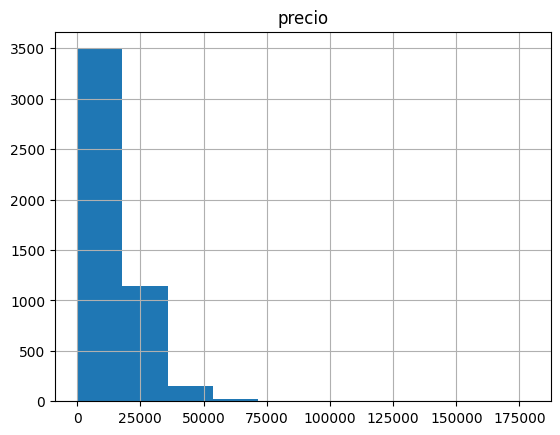

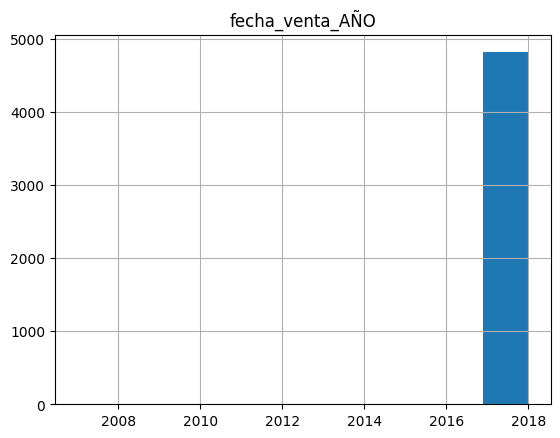

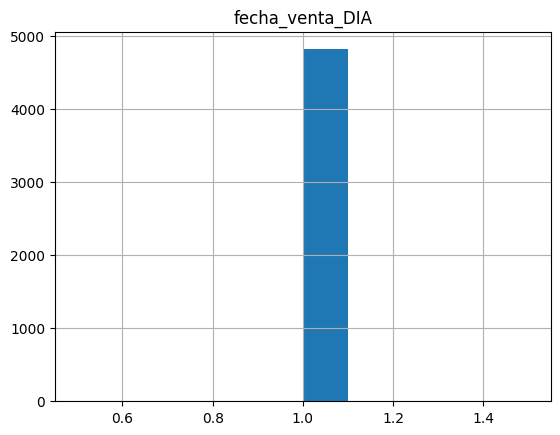

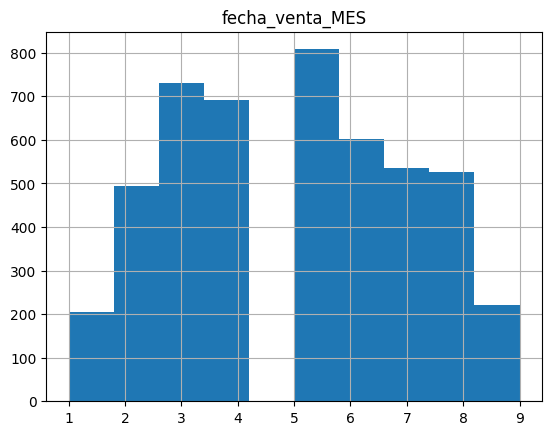

In [472]:
unicos(df3)

In [473]:
df3["tipo_gasolina"]=df3["tipo_gasolina"].replace({"Diesel":"diesel"})

In [474]:
df3.drop(df3.loc[(df3["tipo_gasolina"]=="hybrid_petrol") | (df3["tipo_gasolina"]=="electro"),"tipo_gasolina"].index,inplace=True)

In [475]:
df3.reset_index(drop=True,inplace=True)

In [476]:
del(df3["fecha_venta_DIA"])

In [477]:
del(df3["fecha_venta_AÑO"])

In [478]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4806 entries, 0 to 4805
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   modelo                       4806 non-null   object 
 1   km                           4806 non-null   float64
 2   potencia                     4806 non-null   float64
 3   tipo_gasolina                4806 non-null   object 
 4   color                        4806 non-null   object 
 5   tipo_coche                   4806 non-null   object 
 6   volante_regulable            4806 non-null   bool   
 7   aire_acondicionado           4806 non-null   bool   
 8   camara_trasera               4806 non-null   bool   
 9   asientos_traseros_plegables  4806 non-null   bool   
 10  elevalunas_electrico         4806 non-null   bool   
 11  bluetooth                    4806 non-null   bool   
 12  gps                          4806 non-null   bool   
 13  alerta_lim_velocid

Tratamiento Outliers

In [479]:
df4=df3.copy()

<Axes: xlabel='precio'>

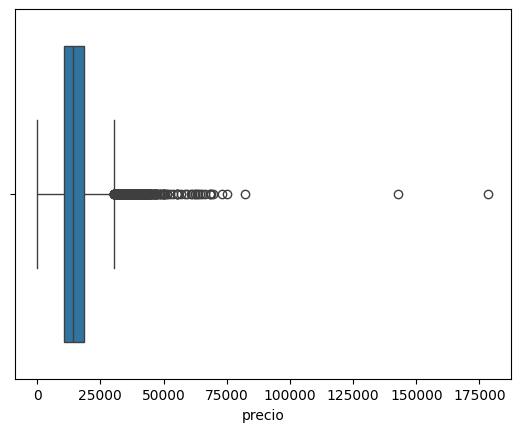

In [480]:
sns.boxplot(x=df4["precio"])

<Axes: xlabel='potencia'>

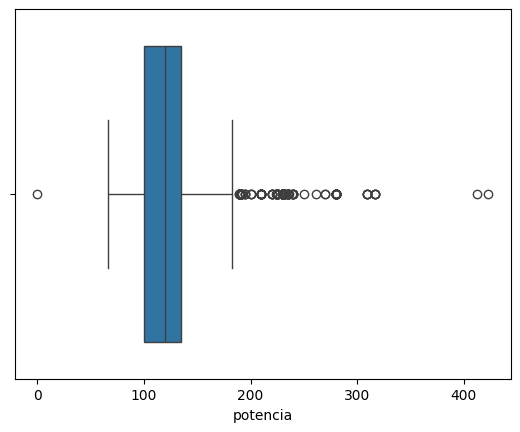

In [481]:
sns.boxplot(x=df4["potencia"])

<Axes: xlabel='km'>

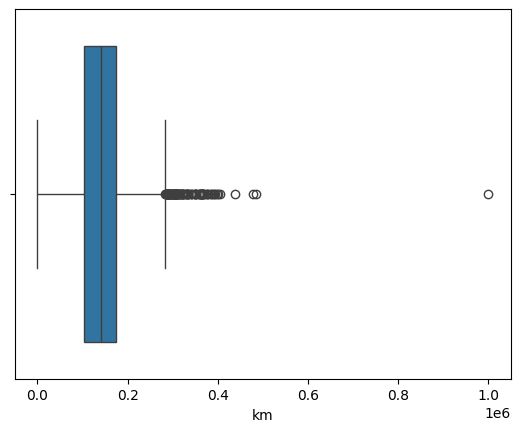

In [482]:
sns.boxplot(x=df4["km"])

In [483]:
df4.iloc[df4.loc[(df4["km"]<=0) | (df4["km"]>500000),"km"].index]

,modelo,km,potencia,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta_MES
2908,640 Gran Coupé,-64.0,230.0,diesel,black,sedan,True,True,False,False,False,False,True,True,75000.0,4
3701,118,1000376.0,90.0,diesel,black,hatchback,True,False,False,False,False,False,True,False,1400.0,6


In [484]:
df4.drop(df4.loc[(df4["km"]<=0) | (df4["km"]>500000),"km"].index,inplace=True)


In [485]:
df4=df4.reset_index(drop=True)

In [486]:
df4.iloc[df4.loc[df4["potencia"]<=0,"potencia"].index]


,modelo,km,potencia,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta_MES
3732,X1,81770.0,0.0,diesel,white,suv,False,False,False,False,False,False,False,False,11700.0,3


In [487]:
df4.drop(df4.loc[df4["potencia"]<=0,"potencia"].index,inplace=True)

In [488]:
df4.reset_index(drop=True,inplace=True)

In [489]:
df4.iloc[df4.loc[df4["precio"]>80000,"precio"].index]

,modelo,km,potencia,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta_MES
4111,X6 M,2970.0,423.0,petrol,red,suv,True,True,True,False,False,False,True,True,82400.0,4
4647,X4,103222.0,140.0,diesel,grey,suv,True,True,False,True,True,False,True,True,142800.0,8
4716,X3,72515.0,135.0,diesel,blue,suv,False,False,True,True,False,False,False,True,178500.0,8


In [490]:
df4.drop(df4.loc[df4["precio"]>80000,"precio"].index,inplace=True)

In [491]:
df4.reset_index(drop=True,inplace=True)

In [492]:
df5=df4.copy()

In [493]:
df5.shape

(4800, 16)

In [494]:
t=analisisvc(df5,"color")
t.head(20)
#modelo 150
#color 300
#tipo_coche 100

,color,count,por,poracum
0,black,1831,38.15,38.15
1,grey,1143,23.81,61.96
2,blue,653,13.60,75.56
3,white,479,9.98,85.54
4,brown,301,6.27,91.81
5,silver,290,6.04,97.85
6,red,46,0.96,98.81
7,beige,37,0.77,99.58
8,green,14,0.29,99.87
9,orange,6,0.12,99.99


In [495]:
otros=obten_lista_otros(df5,"modelo",150)

In [496]:
for i in otros:
    cambiar_a_otros(df5,i)    

In [497]:
otros=obten_lista_otros(df5,"tipo_coche",100)

In [498]:
for i in otros:
    cambiar_a_otros(df5,i)   

# Preproccesing

In [499]:
df6=df5.copy()

## Analisis de Correlación

In [500]:
corr = df6.corr(numeric_only = True)

In [501]:
corr.style.background_gradient(cmap='coolwarm')

,km,potencia,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta_MES
km,1.000000,-0.044021,0.066865,0.022754,0.004316,-0.076592,0.048803,-0.036339,0.156455,-0.017837,-0.428413,-0.001917
potencia,-0.044021,1.000000,0.326573,0.183848,0.315206,0.447621,0.345595,0.230652,0.006201,0.509648,0.677311,-0.028685
volante_regulable,0.066865,0.326573,1.000000,0.286624,0.254065,0.202740,0.278216,0.133291,0.242768,0.243752,0.285518,0.080488
aire_acondicionado,0.022754,0.183848,0.286624,1.000000,0.142784,0.102309,0.256600,0.102986,0.340076,0.205942,0.248028,0.005748
camara_trasera,0.004316,0.315206,0.254065,0.142784,1.000000,0.177311,0.199812,0.133973,0.062018,0.195375,0.265158,0.019771
asientos_traseros_plegables,-0.076592,0.447621,0.202740,0.102309,0.177311,1.000000,0.155069,0.105994,0.021332,0.268643,0.464629,0.076800
elevalunas_electrico,0.048803,0.345595,0.278216,0.256600,0.199812,0.155069,1.000000,0.237329,0.201448,0.338715,0.287510,-0.024015
bluetooth,-0.036339,0.230652,0.133291,0.102986,0.133973,0.105994,0.237329,1.000000,0.116903,0.098874,0.223061,-0.013833
gps,0.156455,0.006201,0.242768,0.340076,0.062018,0.021332,0.201448,0.116903,1.000000,-0.053889,0.009895,0.062330
alerta_lim_velocidad,-0.017837,0.509648,0.243752,0.205942,0.195375,0.268643,0.338715,0.098874,-0.053889,1.000000,0.456401,-0.041608


## Analisis Variables vs Target

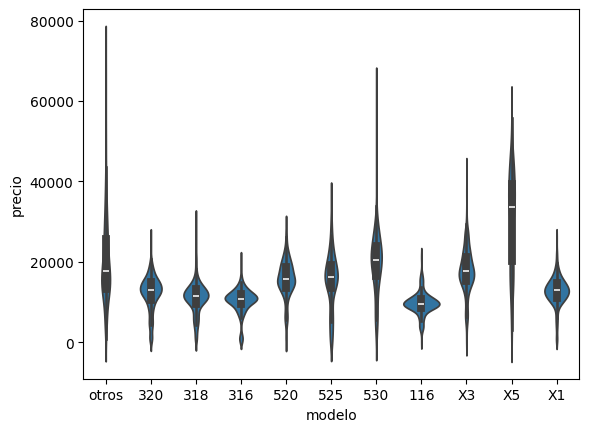

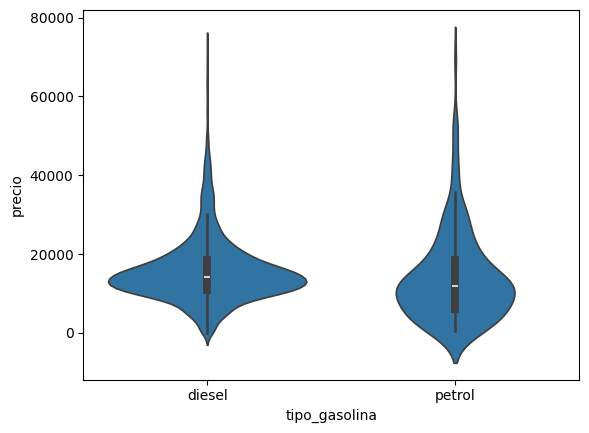

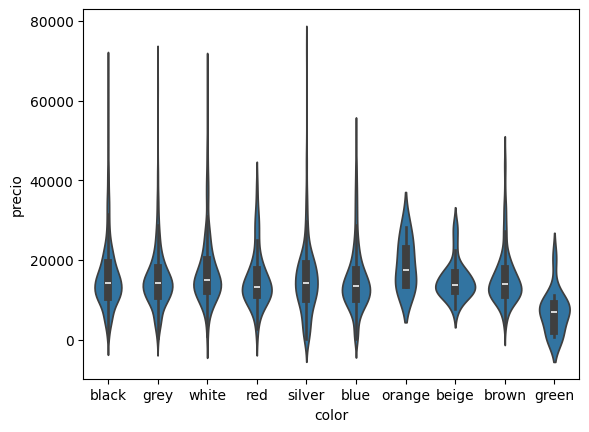

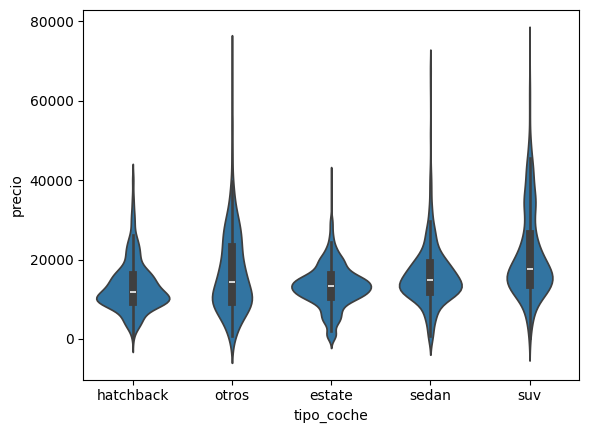

In [502]:
for i in df6:
  if df6[i].dtype.kind in ("O"):
    plt.figure()
    sns.violinplot(x=i,y="precio", data=df6)    

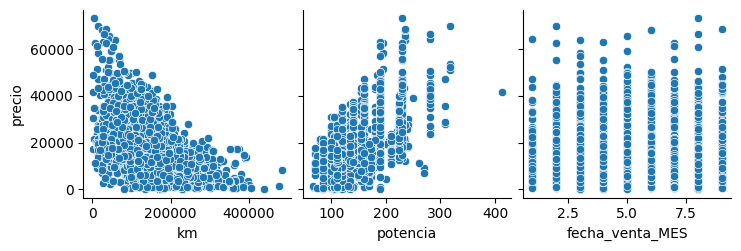

In [519]:
sns.pairplot(df6,x_vars=["km","potencia","fecha_venta_MES"], y_vars=target)
plt.show()

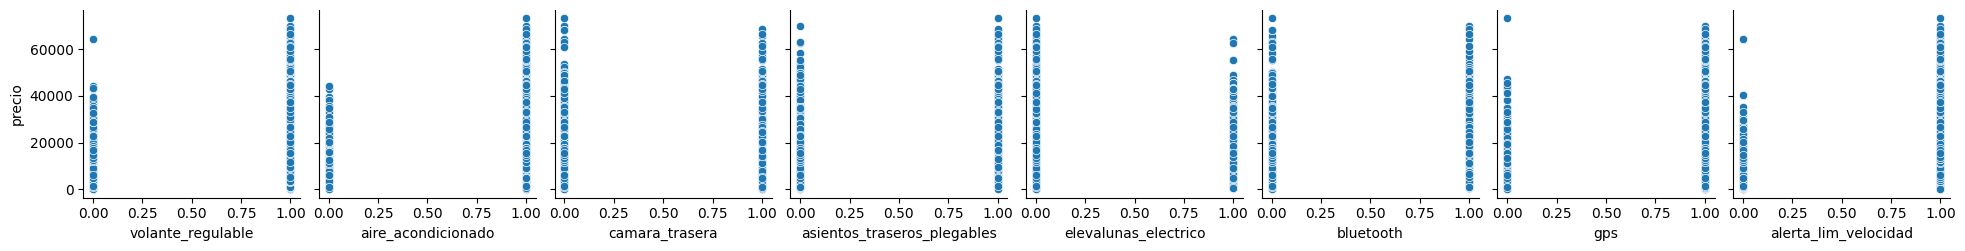

In [503]:
sns.pairplot(df6,x_vars=lbool, y_vars=target)
plt.show()

## Reescalar Categoricas

In [504]:
lnum2, lbool2, lcat2= obtener_lista_variables(df6)

In [505]:
lnum2

['km', 'potencia', 'fecha_venta_MES']

In [506]:
df7=pd.get_dummies(data=df6 ,columns=lcat2)


In [507]:
minMaxResultado=MinMaxScaler()
df7[lnum2]=minMaxResultado.fit_transform(df7[lnum2])

In [508]:
for i in df7:
    if df7[i].dtype.kind=="b":
        df7[i]=df7[i].astype(int)

## Analisis de Varianza

In [509]:
vt = VarianceThreshold(threshold = 0.01)
vt.fit(df7)

cols_lowvar = df7.columns[vt.get_support()==False]
cols_lowvar

Index(['color_beige', 'color_green', 'color_orange', 'color_red'], dtype='object')

In [510]:
df7=df7.drop(columns=cols_lowvar)

## Correlacion Final

In [511]:
corr2 = df7.corr(numeric_only = True)
corr2.style.background_gradient(cmap='coolwarm')

,km,potencia,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta_MES,modelo_116,modelo_316,modelo_318,modelo_320,modelo_520,modelo_525,modelo_530,modelo_X1,modelo_X3,modelo_X5,modelo_otros,tipo_gasolina_diesel,tipo_gasolina_petrol,color_black,color_blue,color_brown,color_grey,color_silver,color_white,tipo_coche_estate,tipo_coche_hatchback,tipo_coche_otros,tipo_coche_sedan,tipo_coche_suv
km,1.000000,-0.044021,0.066865,0.022754,0.004316,-0.076592,0.048803,-0.036339,0.156455,-0.017837,-0.428413,-0.001917,-0.111315,0.004189,0.060790,0.100869,0.095265,0.100524,0.071969,-0.059834,-0.035382,-0.036389,-0.148503,0.035522,-0.035522,0.032728,-0.022258,-0.021716,0.031222,0.025941,-0.069264,0.187012,-0.117300,-0.124949,0.066209,-0.113528
potencia,-0.044021,1.000000,0.326573,0.183848,0.315206,0.447621,0.345595,0.230652,0.006201,0.509648,0.677311,-0.028685,-0.321703,-0.258151,-0.261958,-0.031710,-0.014106,0.113339,0.274025,-0.118274,0.045480,0.348665,0.271796,-0.114674,0.114674,0.028577,-0.002605,-0.056677,-0.002602,0.014053,0.010790,-0.054602,-0.230997,-0.000251,0.031794,0.235385
volante_regulable,0.066865,0.326573,1.000000,0.286624,0.254065,0.202740,0.278216,0.133291,0.242768,0.243752,0.285518,0.080488,-0.194179,-0.130747,-0.096356,-0.094371,0.174396,0.094140,0.100484,-0.097802,0.055796,0.143607,0.063119,0.011727,-0.011727,0.008044,0.014640,0.038885,0.046785,-0.014833,-0.099685,0.014373,-0.169598,-0.031840,0.048340,0.101851
aire_acondicionado,0.022754,0.183848,0.286624,1.000000,0.142784,0.102309,0.256600,0.102986,0.340076,0.205942,0.248028,0.005748,-0.152916,-0.037324,0.009771,-0.042883,0.134192,0.046742,0.069444,-0.107888,-0.008276,0.076347,0.012586,0.090543,-0.090543,0.005916,0.002613,0.047872,0.029258,-0.036971,-0.047431,0.090366,-0.119757,-0.100478,0.060695,-0.005968
camara_trasera,0.004316,0.315206,0.254065,0.142784,1.000000,0.177311,0.199812,0.133973,0.062018,0.195375,0.265158,0.019771,-0.103050,-0.084447,-0.098901,-0.068047,0.003201,0.058020,0.077008,-0.026908,0.018372,0.145887,0.112781,-0.012582,0.012582,0.001208,0.003708,-0.016366,0.011869,0.001258,0.004335,-0.042498,-0.051242,-0.034702,0.002618,0.110575
asientos_traseros_plegables,-0.076592,0.447621,0.202740,0.102309,0.177311,1.000000,0.155069,0.105994,0.021332,0.268643,0.464629,0.076800,-0.135817,-0.108060,-0.170888,-0.168482,-0.170106,-0.058552,-0.024794,-0.075894,0.575031,0.425172,0.023851,0.053211,-0.053211,0.031923,-0.035310,-0.011172,-0.047596,0.056123,0.013902,-0.294067,-0.173667,-0.101741,-0.134818,0.680516
elevalunas_electrico,0.048803,0.345595,0.278216,0.256600,0.199812,0.155069,1.000000,0.237329,0.201448,0.338715,0.287510,-0.024015,-0.172119,-0.152690,-0.151218,-0.003124,0.120397,0.089743,0.128168,-0.101008,0.017166,0.100633,0.109126,-0.007122,0.007122,0.063726,-0.032099,-0.022235,-0.015156,-0.033016,0.016678,0.050961,-0.095739,-0.026445,0.006527,0.031868
bluetooth,-0.036339,0.230652,0.133291,0.102986,0.133973,0.105994,0.237329,1.000000,0.116903,0.098874,0.223061,-0.013833,-0.054423,-0.074677,-0.048192,-0.006656,-0.054106,0.008866,0.039046,-0.079188,0.027203,0.012753,0.162172,-0.035588,0.035588,0.018780,0.010751,-0.050337,-0.040518,-0.016299,0.063230,-0.034235,0.018462,0.074946,-0.015975,-0.000677
gps,0.156455,0.006201,0.242768,0.340076,0.062018,0.021332,0.201448,0.116903,1.000000,-0.053889,0.009895,0.062330,0.031749,0.010193,0.032897,-0.034204,0.062303,0.022713,0.039946,-0.121126,-0.077524,0.028764,0.007430,0.048068,-0.048068,0.033997,0.006815,0.035010,0.028695,-0.029870,-0.110771,0.044847,0.018057,0.002147,0.041608,-0.109569
alerta_lim_velocidad,-0.017837,0.509648,0.243752,0.205942,0.195375,0.268643,0.338715,0.098874,-0.053889,1.000000,0.456401,-0.041608,-0.291778,-0.176379,-0.224470,0.042912,0.115576,0.127127,0.143306,-0.100699,0.098970,0.186485,0.092604,0.007589,-0.007589,0.025921,-0.021630,-0.029710,0.001141,0.013953,0.006932,0.022047,-0.207100,-0.076263,0.045916

In [512]:
target = 'precio'
features = df7.columns[df7.columns!=target]

# Divide dataset en matriz de variables (X) y output (y)
X = df7[features]
y = df7[target]

In [513]:
highly_corr = highly_correlated(X,y,0.95)
highly_corr

C:\Users\rstee\AppData\Local\Temp\ipykernel_3248\3316001217.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  Z['F_to_delete'][Z['corr_F1_target'] < Z['corr_F2_target']] = Z['F1'][Z['corr_F1_target'] < Z['corr_F2_target']]
C:\Users\rstee\

,F1,F2,corr_F1_F2,corr_F1_target,corr_F2_target,F_to_delete
0,tipo_gasolina_petrol,tipo_gasolina_diesel,1.0,0.039922,0.039922,tipo_gasolina_petrol


In [514]:
del(df7["tipo_gasolina_petrol"]) # Al estar inversamente correlacionada con diesel se elimina.

In [515]:
df7.shape

(4800, 35)

In [520]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   km                           4800 non-null   float64
 1   potencia                     4800 non-null   float64
 2   volante_regulable            4800 non-null   int32  
 3   aire_acondicionado           4800 non-null   int32  
 4   camara_trasera               4800 non-null   int32  
 5   asientos_traseros_plegables  4800 non-null   int32  
 6   elevalunas_electrico         4800 non-null   int32  
 7   bluetooth                    4800 non-null   int32  
 8   gps                          4800 non-null   int32  
 9   alerta_lim_velocidad         4800 non-null   int32  
 10  precio                       4800 non-null   float64
 11  fecha_venta_MES              4800 non-null   float64
 12  modelo_116                   4800 non-null   int32  
 13  modelo_316        

In [524]:
dfexcel = df7.iloc[:50]

In [523]:
from pathlib import Path  
filepath = Path("data/df50filas.xlsx")  
filepath.parent.mkdir(parents=True, exist_ok=True)  
dfexcel.to_excel(filepath,index=False) 